# This notebook reads text data from data extract created from FSHA Forms and runs predictive Models to predict the value 'Are there any opp of Abuse?' , based on the Input Data
# It does vectorization of each Column and concatenates these Vectors to create a final Feature Vector and fits the best ML Model from benchmarking study

In [164]:
#import all necessary modules
from __future__ import print_function
import logging
from optparse import OptionParser
import sys
from time import time
import matplotlib.pyplot as plt
import os
import nltk
import string
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import word_tokenize,sent_tokenize
from nltk.tokenize import RegexpTokenizer
import re
import numpy as np
from numpy import array
from numpy import argmax
from scipy import signal
import random
import string
import pandas as pd
from sklearn.model_selection import train_test_split 
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_selection import f_classif
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix  
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.svm import SVC 
from sklearn import svm
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn import tree
from sklearn import linear_model
from sklearn.utils.extmath import density
from sklearn.decomposition import PCA
from sklearn import metrics

import warnings
warnings.simplefilter('ignore')

## File name and other important parameters like ngram_range set

In [165]:
#These parameters will be input from command line
ngram_range_inp=(1,2)
filename = "C:/Pepsico/Base LCS Files Extract_28 Aug 2019_207Files.xlsm"

In [166]:
filename1 = "C:/Pepsico/MLextracts_abuseByConsumer 08 26.xlsm"

# Define reusable modular method for Text Normalization (removal of stopwords, changing to lower case, removal of punctuation etc) 

In [167]:
import pandas as pd
import numpy as np
import nltk
from nltk.tokenize.toktok import ToktokTokenizer
import re
from bs4 import BeautifulSoup
import unicodedata

tokenizer = ToktokTokenizer()
stopword_list = nltk.corpus.stopwords.words('english')
stopword_list.remove('no')
stopword_list.remove('not')
def strip_html_tags(text):
    soup = BeautifulSoup(text, "html.parser")
    stripped_text = soup.get_text()
    return stripped_text
def remove_accented_chars(text):
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    return text

def remove_special_characters(text):
    text = re.sub('[^a-zA-z0-9\s]', '', text)
    return text

def remove_stopwords(text, is_lower_case=False):
    tokens = tokenizer.tokenize(text)
    tokens = [token.strip() for token in tokens]
    if is_lower_case:
        filtered_tokens = [token for token in tokens if token not in stopword_list]
    else:
        filtered_tokens = [token for token in tokens if token.lower() not in stopword_list]
    filtered_text = ' '.join(filtered_tokens)    
    return filtered_text
def normalize_corpus(corpus, html_stripping=True, contraction_expansion=True,
                     accented_char_removal=True, text_lower_case=True, 
                     text_lemmatization=True, special_char_removal=True, 
                     stopword_removal=True):
    
    normalized_corpus = []
    # normalize each document in the corpus
    #corpus = str(corpus)
    for doc in corpus:
        # strip HTML
        if html_stripping:
            doc = strip_html_tags(doc)
        # remove accented characters
        if accented_char_removal:
            doc = remove_accented_chars(doc)

        # lowercase the text    
        if text_lower_case:
            doc = doc.lower()
        # remove extra newlines
        doc = re.sub(r'[\r|\n|\r\n]+', ' ',doc)
        # insert spaces between special characters to isolate them    
        special_char_pattern = re.compile(r'([{.(-)!}])')
        doc = special_char_pattern.sub(" \\1 ", doc)
        # remove special characters    
        if special_char_removal:
            doc = remove_special_characters(doc)  
        # remove extra whitespace
        doc = re.sub(' +', ' ', doc)
        # remove stopwords
        if stopword_removal:
            doc = remove_stopwords(doc, is_lower_case=text_lower_case)
            
        normalized_corpus.append(doc)
        
    return normalized_corpus

# Read the data extract file (tabular format with Input data(X) and target(Y))

In [168]:
fsha_data = pd.read_excel(filename)

In [169]:
len(fsha_data)

207

In [170]:
fsha_data = fsha_data[(fsha_data['abuseByConsumer']=='No')]

In [171]:
len(fsha_data)

204

In [172]:
fsha_data_yes = pd.read_excel(filename1)

In [173]:
len(fsha_data_yes)

23

In [174]:
fsha_data = pd.concat([fsha_data,fsha_data_yes])

In [175]:
len(fsha_data)

227

In [176]:
fsha_data.abuseByConsumer.value_counts()

No     204
Yes     23
Name: abuseByConsumer, dtype: int64

In [177]:
fsha_data.head()

,File Name,projName,accolNumber,PDA_projName,projType,projDesc,formulaNumber,owner,sector,center,...,prodModifications,newIngredient,approvedPackage,potentialMicrobial,crossContactAllergens,chokeHazard,operationalAllergen,abuseByConsumer,cookstepByConsumer,allergensLabeledIMAF
0,FSHA 46694 Lays Ridge.xlsm,Lays Ridge launch,46694,"Lay's Wavy Spring Onion, Lay's Wavy Sour Cream,",Category Reframe,Significant launch of new subline within exist...,"P02806, PP03084 (PF03211)","Artur Zyśk, +48723990114",ESSA,"Warsaw, Poland",...,No,Yes,No,No,Yes,No,Yes,No,No,"Milk, Lactose : Milk, Lactose"
1,FSHA 5.4.1 - Doritos Sweet Chilli Pepper Na Re...,Sodium reduction Doritos Sweet Chilli Pepper I...,39660,Doritos Sweet Chilli Pepper,Refresh,Sodium reduction project to conform to Legisla...,999010432 Doritos Sweet Chilli Pepper,Sherwin Tlhoaele / Gabisile Buthelezi,ESSA,South Africa,...,No,No,No,No,No,No,Yes,No,No,Not Applicable : Not Applicable : Soya
2,FSHA 5.4.1 - Doritos Sweet Chilli Pepper Na Re...,Sodium reduction Doritos Sweet Chilli Pepper P...,39660,Doritos Sweet Chilli Pepper,Refresh,Sodium reduction project to conform to Legisla...,999010432 Doritos Sweet Chilli Pepper,Sherwin Tlhoaele / Gabisile Buthelezi,ESSA,South Africa,...,No,No,No,No,No,No,Yes,No,No,Not Applicable : Not Applicable : Soya
3,FSHA 5.4.1 - Lay's BBQ Gate 3 Prospecton 5.04....,Lay's Barbecue Flavoured Potato Chips,50169,Lay's Barbecue Flavoured Potato Chips,Refresh,New flavour for the Lay's range - Lay's Barbecue,not provided,Xolelwa Nzuzo,ESSA,South Africa,...,No,Yes,No,No,Yes,No,Yes,No,No,Not Applicable : Not Applicable
4,FSHA 5.4.1 - Simba Cheese & Onion NA Reduction...,Simba Cheese & Onion Sodium Reduction Isando,39660,Simba Cheese & Onion,Renovation,Sodium Reduction Project to conform to Legisla...,Simba Potato Chips (ZBR for different flavoure...,Lizel Laubscher,ESSA,South Africa,...,No,No,No,No,Yes,No,Yes,No,No,Not Applicable : Not Applicable : Dairy (Cows ...


# Based on Analysis select the Features (X)

In [178]:
#selecting set of columns as Features
fsha_data.fillna('NA', inplace=True)
features_df=fsha_data[['PDA_projName', 'projDesc','formulaNumber','CPD-ProdName-Desc','packMaterial','prodStorageDist','shelfLife',
    'TCG','cookedOrHeated', 'specificStorage','labelingInstructions','mishandled','targetMarket','approvedPackage']]

In [179]:
def conv_str(x):
   
    x=str(x)
    x=x.lower()
    return (x)

features_df['PDA_projName']=features_df['PDA_projName'].apply(lambda x:conv_str(x))  
features_df['projDesc']=features_df['projDesc'].apply(lambda x:conv_str(x))
features_df['formulaNumber']=features_df['formulaNumber'].apply(lambda x:conv_str(x)) 
features_df['packMaterial']=features_df['packMaterial'].apply(lambda x:conv_str(x))  
features_df['CPD-ProdName-Desc']=features_df['CPD-ProdName-Desc'].apply(lambda x:conv_str(x))  
features_df['prodStorageDist']=features_df['prodStorageDist'].apply(lambda x:conv_str(x)) 
features_df['shelfLife']=features_df['shelfLife'].apply(lambda x:conv_str(x))  
features_df['TCG']=features_df['TCG'].apply(lambda x:conv_str(x)) 
features_df['cookedOrHeated']=features_df['cookedOrHeated'].apply(lambda x:conv_str(x)) 
features_df['specificStorage']=features_df['specificStorage'].apply(lambda x:conv_str(x)) 
features_df['labelingInstructions']=features_df['labelingInstructions'].apply(lambda x:conv_str(x)) 
features_df['mishandled']=features_df['mishandled'].apply(lambda x:conv_str(x))  
features_df['targetMarket']=features_df['targetMarket'].apply(lambda x:conv_str(x)) 
features_df['approvedPackage']=features_df['approvedPackage'].apply(lambda x:conv_str(x)) 

In [180]:
train_df = features_df

# Define reusable code to Vectorize Text columns (ex:targetMarket) using TF-IDF Vectorizer, after doing Text data normalization

In [181]:
# Vectorization of text data using TF-IDF Vectorizer

# Whether text should be split into word or character n-grams.
# One of 'word', 'char'.
TOKEN_MODE = 'word'

# Minimum document/corpus frequency below which a token will be discarded.
MIN_DOCUMENT_FREQUENCY = 2

# Limit on the length of text sequences. Sequences longer than this
# will be truncated.
MAX_SEQUENCE_LENGTH = 500
ngram_range = n_gram_range
n_gram_range = (1,2)
kwargs = {
            'ngram_range': ngram_range,  # Use 1-grams + 2-grams.
            'dtype': 'int32',
            'strip_accents': 'unicode',
            'decode_error': 'replace',
            'analyzer': TOKEN_MODE,  # Split text into word tokens.
            'min_df': MIN_DOCUMENT_FREQUENCY,
    }
vectorizer = TfidfVectorizer(**kwargs)

def ngram_vectorize(train_texts, train_labels,ngram_range):
    """Vectorizes texts as ngram vectors.

    1 text = 1 tf-idf vector the length of vocabulary of uni-grams + bi-grams.

    # Arguments
        train_texts: list, training text strings.
        train_labels: np.ndarray, training labels.
        val_texts: list, validation text strings.

    # Returns
        x_train, x_val: vectorized training and validation texts
    """
    # Create keyword arguments to pass to the 'tf-idf' vectorizer.
    

    # Learn vocabulary from training texts and vectorize training texts.
    x_train = vectorizer.fit_transform(train_texts)

    x_train = x_train.astype('float32')
    return x_train

# Normalize each column , by cleaning the text

In [182]:
train_df['PDA_projName']=normalize_corpus(train_df['PDA_projName'])
train_df['projDesc']=normalize_corpus(train_df['projDesc'])
train_df['formulaNumber']=normalize_corpus(train_df['formulaNumber'])
train_df['packMaterial']=normalize_corpus(train_df['packMaterial'])  
train_df['CPD-ProdName-Desc']=normalize_corpus(train_df['CPD-ProdName-Desc'])
train_df['prodStorageDist']=normalize_corpus(train_df['prodStorageDist'])
train_df['shelfLife']=normalize_corpus(train_df['shelfLife'])
train_df['TCG']=normalize_corpus(train_df['TCG'])
train_df['cookedOrHeated']=normalize_corpus(train_df['cookedOrHeated'])
train_df['specificStorage']=normalize_corpus(train_df['specificStorage'])
train_df['labelingInstructions']=normalize_corpus(train_df['labelingInstructions']) 
train_df['mishandled']=normalize_corpus(train_df['mishandled']) 
train_df['targetMarket']=normalize_corpus(train_df['targetMarket'])
train_df['approvedPackage']=normalize_corpus(train_df['approvedPackage'])

In [183]:
#Check normalized text
train_df['shelfLife'][:5]

0                                       18 1 week
1    code date 16 weeks export code date 24 weeks
2    code date 16 weeks export code date 24 weeks
3       16 weeks sa market 26 weeks export market
4       16 weeks sa market 26 weeks export market
Name: shelfLife, dtype: object

# Binarize the target (1/0 for Yes/No)

In [184]:
import statistics 

def impute_target(fsha_data,targetName):
    train_y=[]
    for i in range (len(fsha_data)):
        if fsha_data[targetName].values[i]=='Yes':
            train_y.append(1)
        elif fsha_data[targetName].values[i]=='No':
            train_y.append(0)
        else:
            train_y.append(-1)
               
    mode_y = statistics.mode(train_y)

    for i in range (len(fsha_data)):
        if train_y[i]==-1:
            train_y[i] = mode_y
            
    return train_y

# Target (Yes/No choice) in PDAF are converted to binary values

In [185]:
train_y_abuse = impute_target(fsha_data,"abuseByConsumer")

In [186]:
train_df['target']=train_y_abuse

In [187]:
train_df['target'].value_counts()

0    204
1     23
Name: target, dtype: int64

In [188]:
y = train_df['target']
train_df = train_df.drop('target',axis=1)

# Perform n-gram vectorization and PCA on text data, columnwise (2 components per column) and concatenate the values

In [189]:
n_gram_range = (1,2)
n_components = 2
whiten = False
random_state = 42
svd_solver="full"
pca = PCA(n_components=n_components,svd_solver=svd_solver,whiten=whiten, random_state=42)
scaler = StandardScaler()

def preprocess_text(train_df,y):    
    train_labels = y
    x_ngram_projName=ngram_vectorize(train_df['PDA_projName'], train_labels,n_gram_range).toarray()
    x_ngram_projDesc=ngram_vectorize(train_df['projDesc'], train_labels,n_gram_range).toarray()
    x_ngram_formula=ngram_vectorize(train_df['formulaNumber'], train_labels,n_gram_range).toarray()
    x_ngram_packMaterial=ngram_vectorize(train_df['packMaterial'], train_labels,n_gram_range).toarray() 
    x_ngram_CPD_ProdName_Desc=ngram_vectorize(train_df['CPD-ProdName-Desc'], train_labels,n_gram_range).toarray()
    x_ngram_prodStorageDist=ngram_vectorize(train_df['prodStorageDist'], train_labels,n_gram_range).toarray()
    x_ngram_shelfLife=ngram_vectorize(train_df['shelfLife'], train_labels,n_gram_range).toarray()
    x_ngram_TCG=ngram_vectorize(train_df['TCG'], train_labels,n_gram_range).toarray() 
    x_ngram_cookedOrHeated=ngram_vectorize(train_df['cookedOrHeated'], train_labels,n_gram_range).toarray() 
    x_ngram_specificStorage=ngram_vectorize(train_df['specificStorage'], train_labels,n_gram_range).toarray() 
    x_ngram_labelingInstructions=ngram_vectorize(train_df['labelingInstructions'], train_labels,n_gram_range).toarray()
    x_ngram_mishandled=ngram_vectorize(train_df['mishandled'], train_labels,n_gram_range).toarray() 
    x_ngram_targetMarket=ngram_vectorize(train_df['targetMarket'], train_labels,n_gram_range).toarray()
    x_ngram_approvedPackage=ngram_vectorize(train_df['approvedPackage'], train_labels,n_gram_range).toarray()
    train_df = train_df.drop(['PDA_projName','projDesc','formulaNumber','packMaterial','CPD-ProdName-Desc','prodStorageDist','shelfLife','TCG','cookedOrHeated','specificStorage','labelingInstructions','mishandled','targetMarket','approvedPackage'],axis=1)
    
    
    
    x_ngram_projName = scaler.fit_transform(x_ngram_projName)
    x_ngram_projDesc = scaler.fit_transform(x_ngram_projDesc)
    x_ngram_formula = scaler.fit_transform(x_ngram_formula)
    x_ngram_packMaterial = scaler.fit_transform(x_ngram_packMaterial)
    x_ngram_CPD_ProdName_Desc = scaler.fit_transform(x_ngram_CPD_ProdName_Desc)
    x_ngram_prodStorageDist = scaler.fit_transform(x_ngram_prodStorageDist)
    x_ngram_shelfLife = scaler.fit_transform(x_ngram_shelfLife)
    x_ngram_TCG = scaler.fit_transform(x_ngram_TCG)
    x_ngram_cookedOrHeated = scaler.fit_transform(x_ngram_cookedOrHeated)
    x_ngram_specificStorage = scaler.fit_transform(x_ngram_specificStorage)
    x_ngram_labelingInstructions = scaler.fit_transform(x_ngram_labelingInstructions)
    x_ngram_mishandled = scaler.fit_transform(x_ngram_mishandled)
    x_ngram_targetMarket = scaler.fit_transform(x_ngram_targetMarket)
    x_ngram_approvedPackage = scaler.fit_transform(x_ngram_approvedPackage)
    
    x_pca_projName = pca.fit_transform(x_ngram_projName)
    x_pca_projDesc = pca.fit_transform(x_ngram_projDesc)
    x_pca_formula = pca.fit_transform(x_ngram_formula)
    x_pca_packMaterial = pca.fit_transform(x_ngram_packMaterial)
    x_pca_CPD_ProdName_Desc = pca.fit_transform(x_ngram_CPD_ProdName_Desc)
    x_pca_prodStorageDist = pca.fit_transform(x_ngram_prodStorageDist)
    x_pca_shelfLife = pca.fit_transform(x_ngram_shelfLife)
    x_pca_TCG = pca.fit_transform(x_ngram_TCG)
    x_pca_cookedOrHeated = pca.fit_transform(x_ngram_cookedOrHeated)
    x_pca_specificStorage = pca.fit_transform(x_ngram_specificStorage)
    x_pca_labelingInstructions = pca.fit_transform(x_ngram_labelingInstructions)
    x_pca_mishandled = pca.fit_transform(x_ngram_mishandled)
    x_pca_targetMarket = pca.fit_transform(x_ngram_targetMarket)
    x_pca_approvedPackage = pca.fit_transform(x_ngram_approvedPackage)

    x_train = np.concatenate((x_pca_projName,x_pca_projDesc,x_pca_formula,x_pca_packMaterial,x_pca_CPD_ProdName_Desc,
                              x_pca_prodStorageDist,x_pca_shelfLife,x_pca_TCG,x_pca_cookedOrHeated,x_pca_specificStorage,x_pca_labelingInstructions,x_pca_mishandled,x_pca_targetMarket,x_pca_approvedPackage),axis=1)
    print(x_train.shape)
    return x_train  

In [190]:
from sklearn.externals import joblib
X_features = preprocess_text(train_df,y)
joblib.dump(scaler, "scaler_oppabuse.pkl")
joblib.dump(pca, "pca_oppabuse.pkl")
joblib.dump(vectorizer,"vectorizer_oppabuse.pkl")

(227, 28)


['vectorizer_oppabuse.pkl']

In [191]:
y.shape

(227,)

# Perform train test split

In [192]:
X_train, X_test, y_train, y_test = train_test_split(X_features, y, test_size=.2, random_state=42,stratify = y)

In [193]:
print(X_train.shape)
print(X_test.shape)

(181, 28)
(46, 28)


In [194]:
X_train = pd.DataFrame(X_train)
y_train = pd.DataFrame(y_train)

In [195]:
#X_train.columns = ['PCA_allergens_1','PCA_allergens_2','PCA_allergens_3','PCA_allergens_4','PCA_allergens_5','PCA_allergens_6','PCA_allergens_M_1','PCA_allergens_M_2','PCA_allergens_M_3','PCA_allergens_M_4','PCA_allergens_M_5','PCA_allergens_M_6']

In [196]:
print(X_train.shape)
print(y_train.shape)

(181, 28)
(181, 1)


In [197]:
X_train.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)

In [198]:
X_train.head()

,0,1,2,3,4,5,6,7,8,9,...,18,19,20,21,22,23,24,25,26,27
0,-0.213613,-0.406524,-1.628742,-0.831830,-0.519215,-0.347381,-0.413723,-0.438325,-0.752045,-0.870288,...,-0.680027,-0.965795,-0.666259,-0.492769,0.054003,-1.758757,-1.087704,-0.150070,-0.233021,6.885145e-08
1,-0.452320,-0.443179,-1.439855,-0.578417,-0.519215,-0.347381,-0.413723,-0.438325,-0.705390,-0.888516,...,-1.079985,-4.107902,-0.670338,-0.497468,0.064585,-1.576816,-0.995784,-0.125885,-0.233021,6.885145e-08
2,-4.123102,43.843384,-1.668024,-1.059773,62.993397,0.936517,-0.425953,-0.447513,-1.079254,-1.833803,...,0.202513,-1.270825,-0.666259,-0.492769,0.054003,-1.758757,8.736084,-3.996828,-0.233021,6.885145e-08
3,45.237499,3.393736,4.218925,94.691284,-0.504280,-0.333946,-0.425953,-0.447513,-0.784086,-0.938204,...,-0.680027,-0.965795,-0.666259,-0.492769,0.054003,-1.758757,-1.464820,-0.863988,-0.233021,6.885145e-08
4,-0.305454,-0.275335,-1.348129,-0.523758,-0.464532,-0.299139,-0.425953,-0.447513,-0.703264,0.088893,...,-0.378168,-0.810218,-0.803340,-0.685610,-1.775446,10.869046,17.116545,-2.110739,-0.233021,6.885145e-08


# Upsample the oppAbuse=Y data, since the data is highly imbalanced

In [199]:
from sklearn.utils import resample

# concatenate our training data back together
X = pd.concat([X_train, y_train], axis=1)

# separate minority and majority classes
not_abuse = X[X.target==0]
abuse = X[X.target==1]

In [200]:
print(len(not_abuse))
print(len(abuse))

163
18


In [201]:
# upsample minority
abuse_upsampled = resample(abuse,
                          replace=True, # sample with replacement
                          n_samples=len(not_abuse), # match number in majority class
                          random_state=27) # reproducible results

# combine majority and upsampled minority
upsampled = pd.concat([abuse_upsampled, not_abuse])

In [202]:
upsampled.target.value_counts()

1    163
0    163
Name: target, dtype: int64

In [203]:
y_train = upsampled.target
X_train = upsampled.drop('target', axis=1)

In [204]:
X_train.shape

(326, 28)

# Fit the LinearSVC since the benchmarking study shows this model giving best results

In [205]:
from datetime import datetime
import time
selector = SelectKBest(f_classif, k='all')
selector_clf = Pipeline([('selector', selector),('classifier', LinearSVC(loss='l2', penalty='l2',dual=False, tol=1e-3))])
selector_clf.fit(X_train, y_train)
pred = selector_clf.predict(X_test)
pred_train = selector_clf.predict(X_train)

f1_score = metrics.f1_score(y_test, pred)
print("f1_score:   %0.3f" % f1_score )
    
f1_score_train = metrics.f1_score(y_train, pred_train)
print("f1_score_train:   %0.3f" % f1_score_train )
    
print("classification report:")
print(classification_report(y_test, pred))
    
print("confusion matrix:")
print(metrics.confusion_matrix(y_test, pred))
y_pred = pred


f1_score:   0.889
f1_score_train:   0.972
classification report:
             precision    recall  f1-score   support

          0       0.98      1.00      0.99        41
          1       1.00      0.80      0.89         5

avg / total       0.98      0.98      0.98        46

confusion matrix:
[[41  0]
 [ 1  4]]


# Let us plot the Confusion Matrix for the opportunity of Abuse prediction

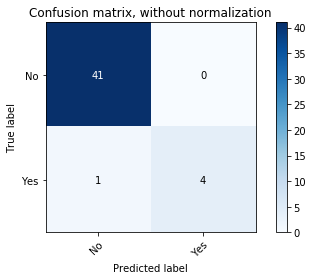

In [206]:
from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    #classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
   # else:
        #print('Confusion matrix, without normalization')

    #print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


np.set_printoptions(precision=2)

class_names=['No','Yes']
# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
#plot_confusion_matrix(y_test, y_pred, classes=class_names, normalize=True,
#                      title='Normalized confusion matrix')

plt.show()

# Let us plot the ROC-AUC for the boolean opportunity of Abuse prediction

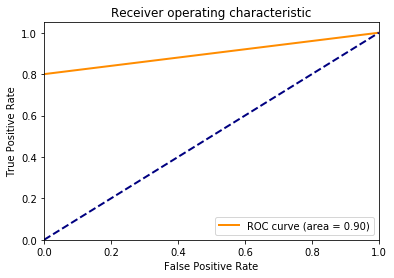

In [207]:
from sklearn.metrics import roc_curve, auc
true_labels = y_test
scores = y_pred

# compute fpr, tpr, thresholds and roc_auc
fpr, tpr, thresholds = roc_curve(true_labels, scores)
roc_auc = auc(fpr, tpr) # compute area under the curve
 
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

This shows the Area under ROC Curve is a healthy 0.9

# Let us do K-fold CV on the data and verify the results

In [208]:
from sklearn.model_selection import cross_validate
cv_results = cross_validate(selector_clf.fit(X_features, y), X_features, y,cv=5)

In [209]:
print(cv_results['test_score'].round(2))

[0.98 0.85 0.89 0.93 1.  ]


In [210]:
X_features = pd.DataFrame(X_features)
y = pd.DataFrame(y)

In [211]:
X_features.reset_index(drop=True, inplace=True)
y.reset_index(drop=True, inplace=True)

In [212]:
from sklearn.utils import resample

# concatenate our training data back together
X = pd.concat([X_features, y], axis=1)

# separate minority and majority classes
not_abuse = X[X.target==0]
abuse = X[X.target==1]

In [213]:
print(len(not_abuse))
print(len(abuse))

204
23


In [214]:
# upsample minority
abuse_upsampled = resample(abuse,
                          replace=True, # sample with replacement
                          n_samples=len(not_abuse), # match number in majority class
                          random_state=27) # reproducible results

# combine majority and upsampled minority
upsampled = pd.concat([abuse_upsampled, not_abuse])

In [215]:
upsampled.target.value_counts()

1    204
0    204
Name: target, dtype: int64

In [216]:
y_train = upsampled.target
X_train = upsampled.drop('target', axis=1)

In [217]:
X_train.shape

(408, 28)

In [218]:
X_train[:5]

,0,1,2,3,4,5,6,7,8,9,...,18,19,20,21,22,23,24,25,26,27
223,-1.608035,-2.254374,-1.587290,-0.688586,-1.803438,-14.379501,-0.804433,1.492519,-0.675917,-0.763602,...,-1.067463,-3.342502,-0.646704,-0.470675,0.054003,-1.758757,-1.087704,-0.150070,-0.233021,6.885145e-08
212,-0.593128,-0.584451,-1.568635,-0.883263,1.044781,-0.328200,-2.468253,47.978802,0.121547,-0.782165,...,-0.983296,-2.623570,-0.666259,-0.492769,0.075470,-1.909450,-1.087704,-0.150070,-0.233021,6.885145e-08
220,-0.571220,-0.556690,-1.567366,-0.862292,0.125961,-0.340758,-2.468253,47.978802,0.551821,-0.550835,...,-0.983296,-2.623570,-0.666259,-0.492769,0.075470,-1.909450,-1.087704,-0.150070,-0.233021,6.885145e-08
209,-0.271066,-0.240726,-1.629000,-0.983016,-0.464532,-0.299139,-0.425953,-0.447513,-0.889818,-1.331099,...,-0.601626,-1.858336,-0.666259,-0.492769,0.054003,-1.758757,-0.453086,-0.597902,-0.233021,6.885145e-08
217,-4.123102,43.843384,-1.668024,-1.059773,62.993397,0.936517,-0.425953,-0.447513,-1.079254,-1.833803,...,0.202513,-1.270825,-0.666259,-0.492769,0.054003,-1.758757,8.736084,-3.996828,-0.233021,6.885145e-08


In [219]:
from datetime import datetime
from sklearn.ensemble import RandomForestClassifier
import time
selector = SelectKBest(f_classif, k='all')
selector_clf = Pipeline([('selector', selector),('classifier', RandomForestClassifier(n_estimators=100))])
selector_clf.fit(X_train, y_train)
pred_train = selector_clf.predict(X_train)
y_pred = selector_clf.predict(X_test)

    
f1_score_train = metrics.f1_score(y_train, pred_train)
print("f1_score_train:   %0.3f" % f1_score_train )
    
print("classification report:")
print(classification_report(y_test, y_pred))
    
print("confusion matrix:")
print(metrics.confusion_matrix(y_test, y_pred))

f1_score_train:   1.000
classification report:
             precision    recall  f1-score   support

          0       1.00      1.00      1.00        41
          1       1.00      1.00      1.00         5

avg / total       1.00      1.00      1.00        46

confusion matrix:
[[41  0]
 [ 0  5]]


In [220]:
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_validate
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import ShuffleSplit
#We define custom functions to return count of TP,TN,FP,FN for each fold
def tn(y_train, pred_train): return confusion_matrix(y_train, pred_train)[0, 0]
def fp(y_train, pred_train): return confusion_matrix(y_train, pred_train)[0, 1]
def fn(y_train, pred_train): return confusion_matrix(y_train, pred_train)[1, 0]
def tp(y_train, pred_train): return confusion_matrix(y_train, pred_train)[1, 1]

scoring = {'tp': make_scorer(tp), 'tn': make_scorer(tn),'fp': make_scorer(fp), 'fn': make_scorer(fn)}
cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=42)

selector = SelectKBest(f_classif, k='all')
selector_clf = Pipeline([('selector', selector),('classifier', RandomForestClassifier(n_estimators=100))])
#selector_clf.fit(X_train, y_train)
cv_results = cross_validate(selector_clf.fit(X_train, y_train), X_train, y_train,scoring=scoring, cv=cv)

In [221]:
print("Count of True Positives")
print(cv_results['test_tp']) 
print("Count of True Negatives")
print(cv_results['test_tn']) 
# Getting the test set false negative scores
print("Count of False Negatives")
print(cv_results['test_fn']) 
print("Count of False Positives")
print(cv_results['test_fp']) 

Count of True Positives
[47 43 37 32 38]
Count of True Negatives
[35 38 45 49 44]
Count of False Negatives
[0 0 0 0 0]
Count of False Positives
[0 1 0 1 0]


In [222]:
from sklearn.model_selection import cross_validate
cv_results = cross_validate(selector_clf.fit(X_train, y_train), X_train, y_train,cv=5)

In [223]:
print(cv_results['test_score'])

[1.   0.99 1.   1.   1.  ]


# Saving the model for predictions on validation set

In [224]:
import pickle
from sklearn.externals import joblib
filename = 'C:/Pepsico/finalized_model_oppAbuse.sav'
joblib.dump(selector_clf,filename)

['C:/Pepsico/finalized_model_oppAbuse.sav']

# Loading instances

In [225]:
train_df = train_df[:1]

In [227]:
def preprocess_text(train_df): 
    scaler_load = joblib.load("scaler_oppabuse.pkl")
    pca_load = joblib.load("pca_oppabuse.pkl")
    vectorizer_load = joblib.load("vectorizer_oppabuse.pkl")
    
    x_ngram_projName=vectorizer_load.transform(train_df['PDA_projName']).toarray()
    x_ngram_projDesc=vectorizer_load.transform(train_df['projDesc']).toarray()
    x_ngram_formula=vectorizer_load.transform(train_df['formulaNumber']).toarray()
    x_ngram_packMaterial=vectorizer_load.transform(train_df['packMaterial']).toarray() 
    x_ngram_CPD_ProdName_Desc=vectorizer_load.transform(train_df['CPD-ProdName-Desc']).toarray()
    x_ngram_prodStorageDist=vectorizer_load.transform(train_df['prodStorageDist']).toarray()
    x_ngram_shelfLife=vectorizer_load.transform(train_df['shelfLife']).toarray()
    x_ngram_TCG=vectorizer_load.transform(train_df['TCG']).toarray() 
    x_ngram_cookedOrHeated=vectorizer_load.transform(train_df['cookedOrHeated']).toarray() 
    x_ngram_specificStorage=vectorizer_load.transform(train_df['specificStorage']).toarray() 
    x_ngram_labelingInstructions=vectorizer_load.transform(train_df['labelingInstructions']).toarray()
    x_ngram_mishandled=vectorizer_load.transform(train_df['mishandled']).toarray() 
    x_ngram_targetMarket=vectorizer_load.transform(train_df['targetMarket']).toarray()
    x_ngram_approvedPackage=vectorizer_load.transform(train_df['approvedPackage']).toarray()
    train_df = train_df.drop(['PDA_projName','projDesc','formulaNumber','packMaterial','CPD-ProdName-Desc','prodStorageDist','shelfLife','TCG','cookedOrHeated','specificStorage','labelingInstructions','mishandled','targetMarket','approvedPackage'],axis=1)
    
    
    
    x_ngram_projName =  scaler_load.transform(x_ngram_projName)
    x_ngram_projDesc =  scaler_load.transform(x_ngram_projDesc)
    x_ngram_formula =  scaler_load.transform(x_ngram_formula)
    x_ngram_packMaterial =  scaler_load.transform(x_ngram_packMaterial)
    x_ngram_CPD_ProdName_Desc =  scaler_load.transform(x_ngram_CPD_ProdName_Desc)
    x_ngram_prodStorageDist =  scaler_load.transform(x_ngram_prodStorageDist)
    x_ngram_shelfLife =  scaler_load.transform(x_ngram_shelfLife)
    x_ngram_TCG =  scaler_load.transform(x_ngram_TCG)
    x_ngram_cookedOrHeated =  scaler_load.transform(x_ngram_cookedOrHeated)
    x_ngram_specificStorage =  scaler_load.transform(x_ngram_specificStorage)
    x_ngram_labelingInstructions =  scaler_load.transform(x_ngram_labelingInstructions)
    x_ngram_mishandled =  scaler_load.transform(x_ngram_mishandled)
    x_ngram_targetMarket =  scaler_load.transform(x_ngram_targetMarket)
    x_ngram_approvedPackage =  scaler_load.transform(x_ngram_approvedPackage)
    
   # x_pca_projName = pca_load.transform(x_ngram_projName)
    x_pca_projDesc = pca_load.transform(x_ngram_projDesc)
    x_pca_formula = pca_load.transform(x_ngram_formula)
    x_pca_packMaterial = pca_load.transform(x_ngram_packMaterial)
    x_pca_CPD_ProdName_Desc = pca_load.transform(x_ngram_CPD_ProdName_Desc)
    x_pca_prodStorageDist = pca_load.transform(x_ngram_prodStorageDist)
    x_pca_shelfLife = pca_load.transform(x_ngram_shelfLife)
    x_pca_TCG = pca_load.transform(x_ngram_TCG)
    x_pca_cookedOrHeated = pca_load.transform(x_ngram_cookedOrHeated)
    x_pca_specificStorage = pca_load.transform(x_ngram_specificStorage)
    x_pca_labelingInstructions = pca_load.transform(x_ngram_labelingInstructions)
    x_pca_mishandled = pca_load.transform(x_ngram_mishandled)
    x_pca_targetMarket = pca_load.transform(x_ngram_targetMarket)
    x_pca_approvedPackage = pca_load.transform(x_ngram_approvedPackage)

    x_train = np.concatenate((x_pca_projDesc,x_pca_formula,x_pca_packMaterial,x_pca_CPD_ProdName_Desc,
                              x_pca_prodStorageDist,x_pca_shelfLife,x_pca_TCG,x_pca_cookedOrHeated,x_pca_specificStorage,x_pca_labelingInstructions,x_pca_mishandled,x_pca_targetMarket,x_pca_approvedPackage),axis=1)
    print(x_train.shape)
    return x_train  

In [228]:
X_features=preprocess_text(train_df)

(1, 26)


In [ ]:
X_features

In [229]:
pca_load = joblib.load("pca_oppabuse.pkl")

In [230]:
dir(pca_load)

['__abstractmethods__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_abc_cache',
 '_abc_negative_cache',
 '_abc_negative_cache_version',
 '_abc_registry',
 '_fit',
 '_fit_full',
 '_fit_truncated',
 '_get_param_names',
 'components_',
 'copy',
 'explained_variance_',
 'explained_variance_ratio_',
 'fit',
 'fit_transform',
 'get_covariance',
 'get_params',
 'get_precision',
 'inverse_transform',
 'iterated_power',
 'mean_',
 'n_components',
 'n_components_',
 'n_features_',
 'n_samples_',
 'noise_variance_',
 'random_state',
 'score',
 'score_samples',
 'set_params',
 'singular_values_',
 'svd_solver',
 'tol',
 'transform',
 'whiten

In [ ]:
pca_load.n_features_